In [6]:
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

In [7]:
def parse_fasta(filepath):
    seqs = {}
    with open(filepath) as fasta_file:  # Will close handle cleanly
        identifiers = []
        lengths = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            #print(seq_record)
            #break
            identifiers.append(seq_record.id)
            lengths.append(len(seq_record.seq))
            seqs[seq_record.id]=str(seq_record.seq)
    return seqs

In [8]:
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
    
def hinge(x, exp=1):
    return min(x, 6**exp)
vhinge = np.vectorize(hinge)

#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    #ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
    #                                            x, 1))(np.unique(y)))

    ax_scatter.set_xlabel(("Model Fit ABA"), fontsize=15)
    ax_scatter.set_ylabel("In Vivo Log Fold Change", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(x, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("Model Fit ABA")
    plt.ylabel("In Vivo Log Fold Change")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y
def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [9]:
def create_simple_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(len(perfect_sequence))]
                for coord in coords:
                    row[int(get_position(coord)/9)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [10]:
sequences = parse_fasta('cas13-master-TilingScreens-data/TilingScreens/data/CD71_library_final.fa')
#sequences = parse_fasta('cas13-master-TilingScreens-data/TilingScreens/data/CD71_library_final.fa')

In [11]:
RATES_PATH = 'cas13-master-TilingScreens-data/TilingScreens/data/CD71_count_matrix_normalized_batchcorrected.csv'
#RATES_PATH = 'cas13-master-TilingScreens-data/TilingScreens/data/CD71_count_matrix_normalized_batchcorrected.csv'

In [12]:
df = pd.read_csv(RATES_PATH)

In [13]:
df.head()

,R1_input,R2_input,R1_top,R2_top,R1_bot,R2_bot
crRNA0001:1-23,479.215970,513.175629,527.963946,423.757622,560.233461,529.062609
crRNA0002:3-25,655.262749,580.431274,563.084429,703.956669,833.053485,652.811208
crRNA0003:5-27,720.250902,848.548108,770.137322,751.877843,822.281945,843.082070
crRNA0004:7-29,774.535040,756.875665,700.341763,736.959311,942.730781,868.155623
crRNA0005:9-31,528.658600,590.315969,679.155307,610.299211,613.616884,612.554810


In [14]:
df.shape

(5948, 6)

In [15]:
log_changes = {}
tb = "top"
for i, row in df.iterrows():
    if "FirstOrder_" in i:
        prefix = i.split("_FirstOrder")[0]
        try:
            original = df.loc[prefix]
        except:
            continue
        #print(np.log(original['R1_top']/original['R1_input']), i)
        if df.shape[1] == 9:
            mean_original = np.nanmean([np.log(original['R1_{}'.format(tb)]/original['R1_input']),
                                       np.log(original['R2_{}'.format(tb)]/original['R2_input']),
                                       np.log(original['R3_{}'.format(tb)]/original['R3_input'])])
            mean_current = np.nanmean([np.log(row['R1_{}'.format(tb)]/row['R1_input']),
                                       np.log(row['R2_{}'.format(tb)]/row['R2_input']),
                                       np.log(row['R3_{}'.format(tb)]/row['R3_input'])])
        else:
            mean_original = np.nanmean([np.log(original['R1_{}'.format(tb)]/original['R1_input']),
                                   np.log(original['R2_{}'.format(tb)]/original['R2_input']),])
            mean_current = np.nanmean([np.log(row['R1_{}'.format(tb)]/row['R1_input']),
                                   np.log(row['R2_{}'.format(tb)]/row['R2_input'])])
        log_changes[i] = mean_current-mean_original

In [16]:
log_changes

{'crRNA0015:62-84_FirstOrder_01': -0.15952534088679127,
 'crRNA0015:62-84_FirstOrder_02': -0.16916995072714106,
 'crRNA0015:62-84_FirstOrder_03': -0.1546083550075206,
 'crRNA0015:62-84_FirstOrder_04': -0.04558385800786855,
 'crRNA0015:62-84_FirstOrder_05': -0.06278313296596101,
 'crRNA0015:62-84_FirstOrder_06': 0.029906126453719657,
 'crRNA0015:62-84_FirstOrder_07': 0.03796396008981175,
 'crRNA0015:62-84_FirstOrder_08': 0.0026905040941815443,
 'crRNA0015:62-84_FirstOrder_09': 0.06612452113350144,
 'crRNA0015:62-84_FirstOrder_10': -0.027334301893196807,
 'crRNA0015:62-84_FirstOrder_11': -0.061212137768469836,
 'crRNA0015:62-84_FirstOrder_12': 0.028450750682713348,
 'crRNA0015:62-84_FirstOrder_13': 0.054067740922508004,
 'crRNA0015:62-84_FirstOrder_14': -0.11514076661685534,
 'crRNA0015:62-84_FirstOrder_15': -0.0027531370176203055,
 'crRNA0015:62-84_FirstOrder_16': -0.11207911539450084,
 'crRNA0015:62-84_FirstOrder_17': 0.010539902043379791,
 'crRNA0015:62-84_FirstOrder_18': 0.0522990287

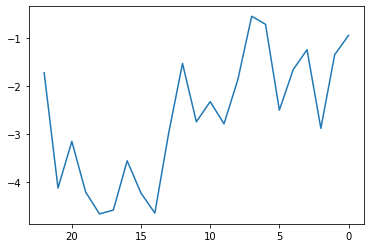

In [17]:
plt.plot([sum([log_changes[x] for x in log_changes if int(x[-2:]) == i]) for i in range(1,24)])
plt.gca().invert_xaxis()

In [18]:
def generate_X_y_CD(sequences, log_changes):
    X = []
    y = []
    for seq in log_changes:
        target_sequence = sequences[seq]
        perfect_match = sequences[seq.split("_FirstOrder")[0]]
        #print(target_sequence, perfect_match)
        coords = get_diff(perfect_match, target_sequence)
        if len(coords) > 5:
            pass
        else:
            dont_count = False
            row = [0 for i in range(9*len(perfect_match))]
            for coord in coords:
                row[get_position(coord)] = 1
                if get_position(coord) >= 9*22:
                    dont_count = True
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            if not dont_count:
                X.append(row)
                y.append(log_changes[seq])
        #print(seq)
    X, y = np.array(X)[:,:198], np.array(y)
    return X, y

In [19]:
X, y = generate_X_y_CD(sequences, log_changes)

In [20]:
y

array([-1.59525341e-01, -1.69169951e-01, -1.54608355e-01, -4.55838580e-02,
       -6.27831330e-02,  2.99061265e-02,  3.79639601e-02,  2.69050409e-03,
        6.61245211e-02, -2.73343019e-02, -6.12121378e-02,  2.84507507e-02,
        5.40677409e-02, -1.15140767e-01, -2.75313702e-03, -1.12079115e-01,
        1.05399020e-02,  5.22990288e-02, -4.74781669e-02,  1.21771099e-01,
       -4.71109930e-02, -3.38249586e-02, -1.53480069e-01, -2.17895216e-01,
       -2.42271814e-01, -2.18114427e-01, -2.76052282e-01, -2.00881190e-01,
       -2.27654848e-01, -1.65140227e-01, -3.06064140e-01, -1.74962164e-01,
       -1.67635069e-01, -2.98813709e-01, -1.78383943e-01, -1.80377483e-01,
       -4.42251373e-01, -2.34383723e-01, -3.13042158e-01, -2.63169389e-01,
       -2.65906211e-01, -2.51633743e-01, -2.22986321e-01, -1.31850139e-01,
        1.10963624e-02, -5.05532354e-02, -1.96855344e-01, -1.33892452e-01,
       -2.31137861e-02, -2.26863771e-01,  8.76448767e-04, -1.10425470e-01,
        4.15940923e-03, -

# Compare to the model we trained earlier

In [22]:
# Time to load in the data
data2 = pd.read_csv("../data7.csv")
energies2 = pd.read_csv("../subopt_attributes7.csv")
energies2["sequence"] = energies2.Sequence.str.slice(29, -32).str.replace("U", "T")
windows2 = pd.read_csv("../vienna_windows7.csv")
windows2["sequence"] = windows2['0'].str.slice(29, -32).str.replace("U", "T")
big_table2 = pd.merge(energies2, data2, on='sequence', how="inner")
big_table2 = pd.merge(big_table2, windows2, on='sequence', how="inner")
#big_table = data
#columns list needed when we add data later
cols2 = list(energies2.columns)
cols2.remove('Sequence')
cols2.remove('sequence')



#now we want to add the ABA column to big_table
perfect_sequence2 = "TTTGATCTGAAATATTCAGGTC"
PERFECT_KD2 = big_table2[big_table2['sequence'] == perfect_sequence2].iloc[0]['kd']
#PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table2['ABA'] = (big_table2.kd/PERFECT_KD2).apply(np.log)
big_table2.head()

##########################
#other table
#########################
# Time to load in the data
data1 = pd.read_csv("../data4.csv")
energies1 = pd.read_csv("../subopt_attributes4.csv")
energies1 = energies1.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
                          'mfold_skew','mfold_median'], axis=1)
energies1["sequence"] = energies1.Sequence.str.slice(29, -32).str.replace("U", "T")
windows1 = pd.read_csv("../vienna_windows4.csv")
windows1["sequence"] = windows1['0'].str.slice(29, -32).str.replace("U", "T")
big_table1 = pd.merge(energies1, data1, on='sequence', how="inner")
big_table1 = pd.merge(big_table1, windows1, on='sequence', how="inner")

#columns list needed when we add data later
cols1 = list(energies1.columns)
cols1.remove('Sequence')
cols1.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence1 = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['kd']
PERFECT_SEQ1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['Sequence']
big_table1['ABA'] = (big_table1.kd/PERFECT_KD1).apply(np.log)
big_table1.head()

,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence,...,delta_y,count,0,0.1,1,5,10,20,40,ABA
0,-21.9,-16.9,-17.643825,2097,0.751334,-1.611854,-17.4,-19.200001,-19.856,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,...,69772.0,54,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,-9.7,-9.7,-9.7,-13.3,-15.3,-21.9,3.808252
1,-23.9,-18.9,-19.735792,1288,0.838893,-1.601279,-19.5,-21.100000,-21.820,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,...,69772.0,80,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,-2.8,-2.8,-2.8,-5.4,-12.1,-23.9,3.678871
2,-15.5,-10.5,-11.225309,10127,0.724902,-1.580592,-11.0,-13.700000,-14.197,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,...,69772.0,61,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-2.9,-2.9,-3.2,-7.7,-9.3,-15.5,1.997113
3,-19.5,-14.5,-15.347548,4894,0.831892,-1.490905,-15.1,-17.700001,-18.254,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,...,69772.0,66,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-0.7,-1.1,-1.5,-5.8,-13.2,-19.5,4.926277
4,-15.7,-10.7,-11.386458,4630,0.699062,-1.641765,-11.2,-13.400000,-13.914,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,...,69772.0,74,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,-1.1,-1.1,-1.5,-5.7,-11.1,-15.7,4.811688


In [24]:
X1, y1 = create_matrix(big_table1, perfect_sequence1)
X2, y2 = create_matrix(big_table2, perfect_sequence2)
X, y = (np.concatenate((X1,X2), axis=0), np.concatenate((y1,y2), axis=0))
X, y = shuffle(X, y)
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1)

In [27]:
X, y = create_matrix(big_table1, perfect_sequence1)
X, y = shuffle(X, y)
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1)

In [82]:
X_prime, y_prime = generate_X_y_CD(sequences, log_changes)

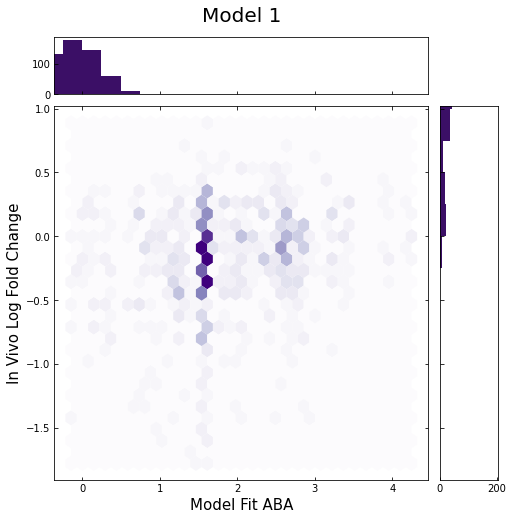

correlation is 0.16791760593366817 p-value 1.70718216627541e-05


In [29]:
predicted_output = X_prime @ reg.coef_ + reg.intercept_
display(y_prime,vhinge(predicted_output),  title="Model 1")
corr, p_value = pearsonr(vhinge(predicted_output), y_prime)
print("correlation is",corr, "p-value", p_value)

In [ ]:
plt.hist(y_prime)

In [ ]:
plt.scatter(X_prime @ reg.coef_ , y_prime)
corr, p_value = pearsonr(X_prime @ reg.coef_ , y_prime)
print("correlation is",corr, "p-value", p_value)

In [ ]:
X_prime[:,:198].shape

In [ ]:
singulars = reg.predict(np.identity(len(X[0])))
arr = singulars#-reg.intercept_

In [ ]:
singulars = reg.predict(np.identity(len(X[0])))
arr = singulars#-reg.intercept_

In [ ]:
arr

In [ ]:
def hist_plot_replacements_avg(arr):
    sub_arr = [arr[elt] for elt in range(len(arr)) if elt % 9 in (4,5,6,7)]
    avged = np.mean(np.array(sub_arr).reshape(-1, 4), axis=1)
    df = pd.DataFrame({"Position": [int(elt/4) for elt in range(len(sub_arr)) if elt%4 == 0],
                        "Action": ["Position" for elt in range(len(sub_arr)) if elt%4 == 0],
                            "Val": avged})
    #df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
    #                                                                          figsize=(20,10), legend=None)
    #plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    #plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    #plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    #plt.xlabel("Position", fontsize=24)
    #plt.title("Average Weights for Substitution Position Features", fontsize=30)
    #plt.show()
    return df.pivot(index = "Position", columns = "Action", values = "Val")['Position'].values


In [ ]:
hist_plot_replacements_avg(arr)

In [ ]:
plt.plot([sum([log_changes[x] for x in log_changes if int(x[-2:]) == i]) for i in range(1,24)])
plt.plot(hist_plot_replacements_avg(arr))
plt.gca().invert_xaxis()

In [ ]:
X_simple = np.array([[max(i) for i in np.array_split(row, 22)] for row in X])
X_prime_simple = np.array([[max(i) for i in np.array_split(row, 22)] for row in X_prime])


In [ ]:
reg.fit(X_simple, y)

In [ ]:
X_prime_simple

In [ ]:
predicted_output = X_prime_simple @ reg.coef_ + reg.intercept_
display(y_prime,vhinge(predicted_output),  title="Model 1")
corr, p_value = pearsonr(vhinge(predicted_output), y_prime)
print("correlation is",corr, "p-value", p_value)


In [ ]:
plt.scatter(X_prime_simple @ reg.coef_ , y_prime)

In [ ]:
reg.coef_

In [ ]:
y_prime.shape

# Compare to Random

In [83]:
def hist_of_random_weights(X, y, gaussian=True, n=100):
    correlations, pvals = [],[]
    for i in range(n):
        if gaussian:
            random_weights = np.random.normal(size=X.shape[1])
            corr, p_value = pearsonr(X @ random_weights, y)
            correlations.append(corr)
            pvals.append(p_value)
            #print("correlation is",corr, "p-value", p_value)
        else:
            random_weights = np.random.normal(size=X.shape[1])
            corr, p_value = pearsonr(X @ random_weights, y)
            correlations.append(corr)
            pvals.append(p_value)
            #print("correlation is",corr, "p-value", p_value)
    return correlations, pvals

In [84]:
corrs, pvals= hist_of_random_weights(X_prime, y_prime, gaussian=False, n = 10000)

Text(0.5, 1.0, 'correlations of random trials')

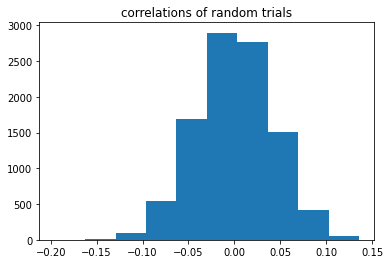

In [85]:
plt.hist(corrs)
plt.title("correlations of random trials")

Text(0.5, 1.0, 'Histogram of p-values')

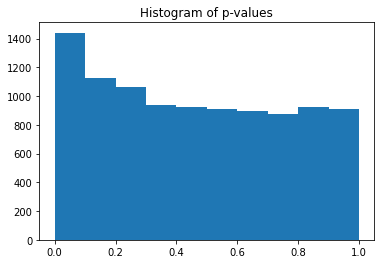

In [86]:
plt.hist(pvals)
plt.title("Histogram of p-values")

In [88]:
corr, p_value = pearsonr(X_prime @ reg.coef_ , y_prime)
print("correlation is",corr, "p-value", p_value)

correlation is 0.11394375346510838 p-value 0.0022136445152051124


In [89]:
np.percentile(pvals, 1)

0.004759935708078323

# Compare to the NN model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#make sure to install keras if you don't have the package yet
from keras import layers, models

In [3]:
#returns a CNN model given training data
def train(X, y, batch_size=100, epochs=100):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    print("input shaped", (len(X[0]), 1, 1))
    
    model = models.Sequential()
    #model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    #model.add(layers.Conv2D(32, (9, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(64, (54, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    

    #model.compile(loss='mean_squared_error',
    #              optimizer='sgd')
    model.compile(loss='logcosh',
                  optimizer='sgd')
    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

#fits the data based on the trained model from above
def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    display(vhinge(model.predict(X_)).reshape(len(X_)), y)
    
    corr, p_value = pearsonr(vhinge((model.predict(X_)).reshape(len(X_))), y)
    print("corr is", corr)
    #return vhinge((model.predict(X_)).reshape(len(X_))), y
    
# no longer necessary  
def without_outliers(model, X, y):
    outliers = []
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    predictions = vhinge((model.predict(X_)).reshape(len(X_)))
    for i in range(len(predictions)):
        if predictions[i]-y[i] > 3:
            print("removing", predictions[i], y[i])
            predictions = np.delete(predictions, i)
            y.pop(i)

In [41]:
# the start of this function is same as before
def create_matrix4(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        
        #row = [0 for i in range(4*max_len)]
        #for i in range(len(seq)):
        #    if seq[i] == 'A':
        #        row[i*4 + 0] = 1
        #    elif seq[i] == 'C':
        #        row[i*4 + 1] = 1
        #    elif seq[i] == 'G':
        #        row[i*4 + 2] = 1
        #    elif seq[i] == 'T':
        #        row[i*4 + 3] = 1
        #    else:
        #        print("Impossible happened check seq values", seq)
        #add_row.extend(row) big change to not include absolute representation
        X_add.append(add_row)
        
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    #X = np.append(X, create_matrix_0(randomize=False)[0], axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    y = preprocessing.scale(y)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [42]:
X1, y1 = create_matrix4(big_table1, perfect_sequence1)
X2, y2 = create_matrix4(big_table2, perfect_sequence2)
X, y = (np.concatenate((X1,X2), axis=0), np.concatenate((y1,y2), axis=0))
X, y = shuffle(X, y)

In [47]:
X.shape

(9537, 324)

In [44]:
def generate_X_y_CD4(sequences, log_changes):
    X = []
    y = []
    max_len = 22
    for seq in log_changes:
        target_sequence = sequences[seq]
        perfect_match = sequences[seq.split("_FirstOrder")[0]]
        #print(target_sequence, perfect_match)
        coords = get_diff(perfect_match, target_sequence)
        if len(coords) > 5:
            pass
        else:
            dont_count = False
            row = [0 for i in range(9*len(perfect_match))]
            for coord in coords:
                row[get_position(coord)] = 1
                if get_position(coord) >= 9*22:
                    dont_count = True
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            if not dont_count:
                X.append(row)
                y.append(log_changes[seq])
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
        #print(seq)
    X, y = np.array(X)[:,:198], np.array(y)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        
        row = [0 for i in range(4*max_len)]
        #for i in range(max_len):
        #    if seq[i] == 'A':
        #        row[i*4 + 0] = 1
        #    elif seq[i] == 'C':
        #        row[i*4 + 1] = 1
        #    elif seq[i] == 'G':
        #        row[i*4 + 2] = 1
        #    elif seq[i] == 'T':
        #        row[i*4 + 3] = 1
        #    else:
        #        print("Impossible happened check seq values", seq)
        #add_row.extend(row) big change to not include absolute representation
        X_add.append(add_row)
        
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    #X = np.append(X, create_matrix_0(randomize=False)[0], axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = preprocessing.scale(y)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [45]:
X_prime, y_prime = generate_X_y_CD4(sequences, log_changes)

In [46]:
X_prime.shape

(719, 324)

In [51]:
X_prime[0]

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.05281477,
       -0.13028095, -0.11258799, -0.11258799,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.12464639, -0.09915372,
       -0.1060743 , -0.09915372,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.09915372, -0.1060743 , -0.11258799,
       -0.11258799,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.09915372, -0.11876183, -0.11876183, -0.09173411,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.07479576, -0.13028095, -0.09915372, -0.11258799,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.09915372,
       -0.11876183, -0.11258799, -0.09915372,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.09915372, -0.06472978,
       -0.12464639, -0.12464639,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.09915372, -0.13028095, -0.11

input shaped (324, 1, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 271, 1, 64)        3520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 1, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                368704    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 372,289
Trainable params: 372,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
96/96 [==============================] - 2s 20ms/step - loss: 0.2503
Epoch 2/

96/96 [==============================] - 2s 18ms/step - loss: 0.1002
Epoch 89/100
96/96 [==============================] - 2s 19ms/step - loss: 0.1050
Epoch 90/100
96/96 [==============================] - 2s 19ms/step - loss: 0.1032
Epoch 91/100
96/96 [==============================] - 2s 18ms/step - loss: 0.1024
Epoch 92/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0984
Epoch 93/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0982
Epoch 94/100
96/96 [==============================] - 2s 18ms/step - loss: 0.1003
Epoch 95/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0985
Epoch 96/100
96/96 [==============================] - 2s 19ms/step - loss: 0.1021
Epoch 97/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0983
Epoch 98/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0981
Epoch 99/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0979
Epoch 100/100
96/96 [========

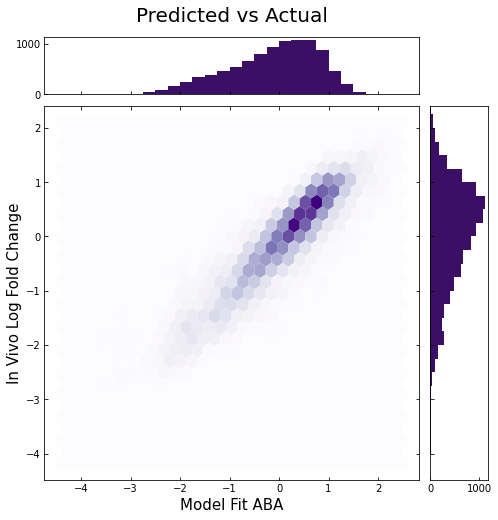

corr is 0.893862825125927


In [53]:
model = train(X, y, epochs=100)
fit(model, X, y)

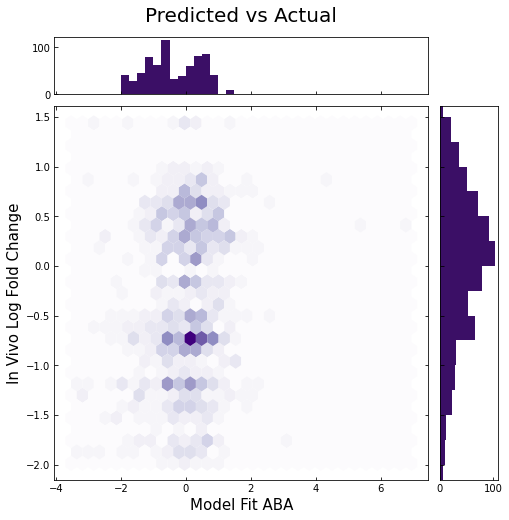

corr is 0.14316222008596355


In [54]:
fit(model, X_prime, y_prime)